In [1]:
from pathlib import Path

import numpy as np
from matplotlib import pyplot as plt
from photon_canon.contrib import calculate_mus
from tqdm import tqdm
from tqdm.contrib import itertools
import scipy.optimize as opt

from hsdfmpm.utils import read_hyperstack
from hsdfmpm.hsdfm import HyperspectralImage, MergedHyperspectralImage
from hsdfmpm.hsdfm.utils import find_cycles, read_metadata_json
from hsdfmpm.hsdfm.contrib import generate_phantom_profiles
from photon_canon.contrib.food_coloring import make_mix
from photon_canon.lut import LUT


# Modelling parameters

In [7]:
lut = LUT(dimensions=['mu_s', 'mu_a'], scale=50000, extrapolate=True, simulation_id=88)
wavelengths = np.arange(520, 610, 10, dtype=float)
ref_wavelength = 720

# Preprocessing constants
To ensure quantitative outputs, all images must be normalized before comparisons.
$$
I'_{\lambda ij} = \frac{
               \frac{I_{\lambda ij}}{\tau_\lambda} - \frac{I^{(\mathrm{bg})}_{\lambda ij}}{\tau^{(\mathrm{bg})}_\lambda}
               }{
               \frac{I^{(\mathrm{std})}_{\lambda ij}}{\tau^{(\mathrm{std})}_\lambda} - \frac{I^{(\mathrm{bg})}_{\lambda ij}}{\tau^{(\mathrm{bg})}_\lambda}
               }
$$

So a background measurement and a standard measurement are needed. Importantly, the standard may have a scalar associated with it that should be factored in prior to normalization.

In [3]:
# Dark background cube
background_cube = HyperspectralImage(image_path=r'E:\new df\04222025\standards\dark\cycle1', wavelengths=wavelengths)
background_cube.normalize()

# Average spectralon standard
standard_paths = find_cycles(r'E:\new df\04222025\standards\standard_080')
standard_cube = MergedHyperspectralImage(image_paths=standard_paths, scalar=0.8, wavelengths=wavelengths)
standard_cube.normalize()


[None, None, None]

# Study design
Before validation on the phantoms, the phantoms must be made.

## Correction-factor Standard
First, a correction factor reference must be prepared. A solution with a known scattering coefficient (using Mie theory) will be prepared and imaged under the same conditions as the phantoms. The model is then used to predict the reflectance from the known scattering coefficients. The difference between the modelled and the measured reflectance is used to calculate a correction factor:

$$
C = \frac{R_e}{R_m}
$$

This correction factor will be applied to all images prior to modelling.

In [110]:
def power_law(x, a, b):
    return a * (x / ref_wavelength) ** -b

To create scattering coefficient: 5 cm^-1.
Dissolve 6.20 uL of beads into  993.80 uL of water.


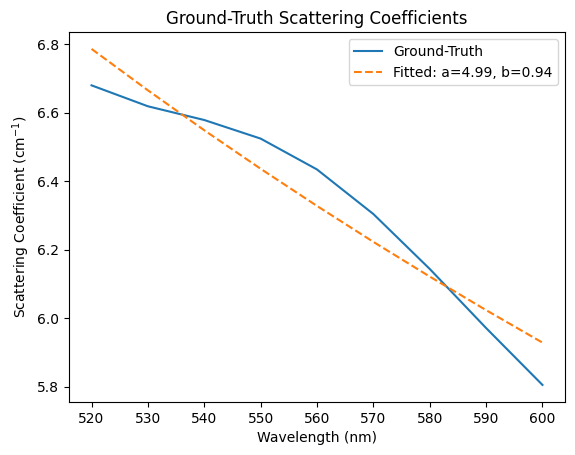

In [111]:
desired_scattering_coef = 5
g = 0.9
reduced_desired = desired_scattering_coef * (1 - g)
mie_theory_result = generate_phantom_profiles(
    wavelengths=wavelengths,
    bead_radius_um=0.746/2, sphere_type="beads",
    tot_vol_ml=1.0, per_sol_percent=2.61,
    mode='both', bead_volumes_ul=np.array([6.20]),
    red_scat_coef=np.array([reduced_desired]),
    ref_wavelength=ref_wavelength)
print(f'To create scattering coefficient: {desired_scattering_coef} cm^{-1}.')
print(f'Dissolve {mie_theory_result['volume_distribution_scatter_ul'][0]:0.2f} uL of beads into  '
     f'{mie_theory_result['volume_distribution_scatter_ul'][1]:0.2f} uL of water.')
ground_truth_mu_s = mie_theory_result['musp_profiles_cm_inv_beads'] / (1 - g)
popt, _ = opt.curve_fit(power_law, wavelengths, ground_truth_mu_s)
a_gt, b_gt = popt[0], popt[1]
fitted_mu_s = power_law(wavelengths, *popt)
plt.plot(wavelengths, ground_truth_mu_s, label='Ground-Truth')
plt.plot(wavelengths, fitted_mu_s, '--', label=f'Fitted: a={a_gt:.2f}, b={b_gt:.2f}')
plt.title('Ground-Truth Scattering Coefficients')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Scattering Coefficient (cm$^{-1}$)')
plt.legend()
plt.show()

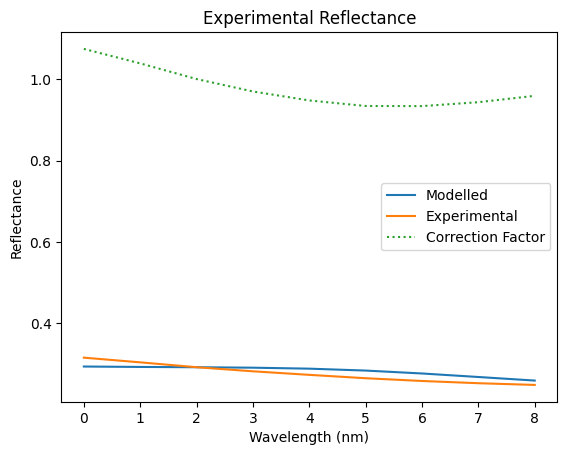

In [9]:
R_m = lut(ground_truth_mu_s, np.zeros_like(ground_truth_mu_s))
plt.plot(R_m, label='Modelled')

R_e = HyperspectralImage(image_path=r'E:\new df\04222025\standards\known_scatterer\cycle1', standard=standard_cube, background=background_cube, wavelengths=wavelengths)
R_e.normalize()
plt.plot(np.nanmean(R_e, axis=(1, 2)), label='Experimental')


C = R_e / R_m[..., np.newaxis, np.newaxis]

plt.plot(np.nanmean(C, axis=(1, 2)), ':', label='Correction Factor')

plt.title('Experimental Reflectance')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Reflectance')
plt.legend()
plt.show()

# Phantom design
Two solutions will be designed from mixtures of food coloring to have similar but distinct spectra in the wavelength range 500-720 nm. The absorption of a 1 $\mu$L / mL sample in water each solution will be measured directly and used as the reference concentration. The stocks will then be dissolved with a fixed concntration but varying amounts of each into a series of phantoms.

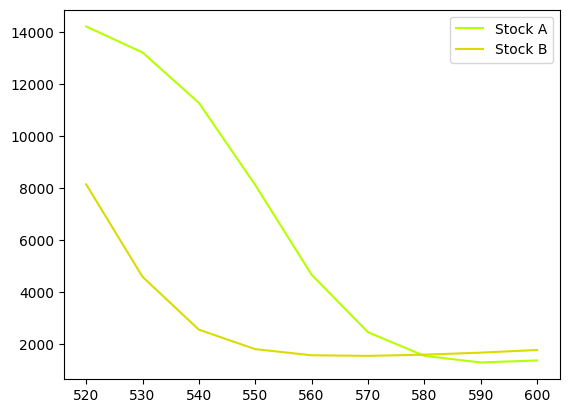

In [10]:
# Make simulated stock solutions
stock_a = make_mix(wavelengths, red=12.5, green=17.5)
stock_b = make_mix(wavelengths, yellow=60.0, blue=0.5)
plt.plot(wavelengths, stock_a, label='Stock A', color=np.array((12.5, 17.5, 0)) / 17.5)
plt.plot(wavelengths, stock_b, label='Stock B', color= np.array((30, 30, 0.5)) / 35)
plt.legend()
plt.show()

## Actual measurements
After determining the ratios for the stock solutions, actual solutions were mixed and the absoprtion of 10 $\mu$L/mL solutions was measured in a 1 cm cuvette. These measures will serve as the ground-truth for the model to fit back to.

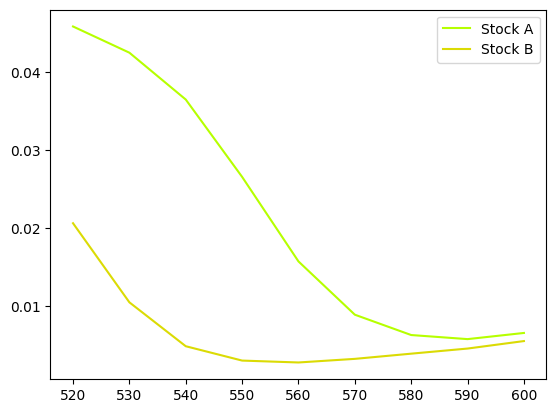

In [11]:
# Loaded actual measurements into photon_canon data
# Make simulated stock solutions
stock_a = make_mix(wavelengths, stock_a=1)
stock_b = make_mix(wavelengths, stock_b=1)
plt.plot(wavelengths, stock_a, label='Stock A', color=np.array((12.5, 17.5, 0)) / 17.5)
plt.plot(wavelengths, stock_b, label='Stock B', color= np.array((30, 30, 0.5)) / 35)
plt.legend()
plt.show()

## Phantom panel


In [12]:
def get_food_coloring_mus(wavelength, a, b, t, s):
    wl0 = 720
    conc_a = s * t
    conc_b = (1 - s) * t
    epsilons = [stock_a * conc_a, stock_b * conc_b]
    mu_s, mu_a, _ = calculate_mus(a, b, [conc_a, conc_b], epsilons, wavelength, wl0, force_feasible=False)
    return mu_s, mu_a

def model_from_food_coloring(wavelength, a, b, t, s):
    if isinstance(a, np.ndarray):
        r = np.zeros((len(wavelengths),) + a.shape)
        for i, j in itertools.product(range(r.shape[1]), range(r.shape[2])):
            mu_s, mu_a = get_food_coloring_mus(wavelength, a[i, j], b[i, j], t[i, j], s[i, j])
            r[:, i, j] = lut(mu_s, mu_a)
    else:
        mu_s, mu_a = get_food_coloring_mus(wavelength, a, b, t, s)
        r = lut(mu_s, mu_a)
    return r

In [13]:
def fit_food_coloring(experimental, guess=(1, 1, 1, 1), bounds=((0, 0, 0, 0), (np.inf, np.inf, np.inf, 1))):
    # Get image shape
    image_shape = experimental.shape
    # experimental[np.logical_or(np.isnan(experimental), np.isinf(experimental))] = 1
    # Create 0 output arrays (ignore 0th dim, spectral)
    a_image = np.zeros(image_shape[1:])
    b_image = np.zeros(image_shape[1:])
    t_image = np.zeros(image_shape[1:])
    s_image = np.zeros(image_shape[1:])

    params = guess
    for i, j in itertools.product(range(image_shape[1]), range(image_shape[2])):
        r = experimental[:, i, j]
        if np.any(np.isnan(r)) or np.any(np.isinf(r)):
            continue
        try:
            params, _, = opt.curve_fit(model_from_food_coloring, wavelengths, r, p0=params, bounds=bounds)
        except RuntimeError:
            params = [np.nan] * 4

        a_image[i, j] = params[0]
        b_image[i, j] = params[1]
        t_image[i, j] = params[2]
        s_image[i, j] = params[3]
        params = guess if np.isnan(params).any() else params

    return a_image, b_image, t_image, s_image

100%|██████████| 5/5 [00:09<00:00,  1.90s/it]


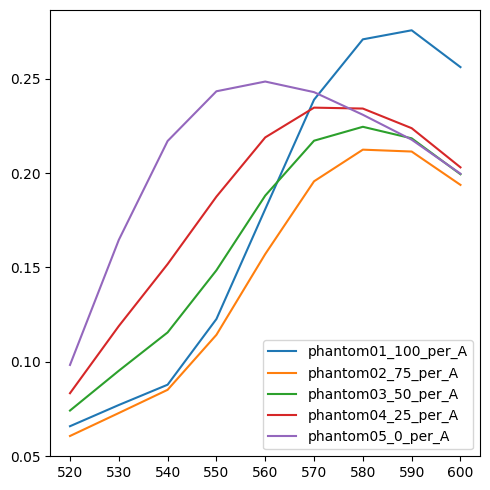

In [14]:
phantom_paths = find_cycles(r'E:\new df\04222025\phantoms')
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
for i, phantom in enumerate(tqdm(phantom_paths)):
    # Load the phantom
    phantom_cube = HyperspectralImage(image_path=phantom, standard=standard_cube, background=background_cube, scalar=C, wavelengths=wavelengths)
    phantom_cube.normalize()

    ax.plot(wavelengths, np.nanmean(phantom_cube, axis=(1, 2)), label=f'{phantom.parts[-2]}')
ax.legend()
plt.tight_layout()
plt.show()

In [116]:
phantom_paths = find_cycles(r'E:\new df\04222025\phantoms')
results = np.zeros((4, len(phantom_paths), 3))  # parameter, phantom, [mean, stdev, actual]
for i, phantom in enumerate(tqdm(phantom_paths)):
    # Load the phantom
    phantom_cube = HyperspectralImage(image_path=phantom, standard=standard_cube, background=background_cube, scalar=1, wavelengths=wavelengths)
    phantom_cube.normalize()
    phantom_cube.bin(bin_factor=1024)

    # Fit it
    a, b, t, s = fit_food_coloring(phantom_cube.image)

    if 'phantom' in phantom.parts[-2]:
        results[0, i, :] = [np.nanmean(a), np.nanstd(a), a_gt]
        results[1, i, :] = [np.nanmean(b), np.nanstd(b), b_gt]
        results[2, i, :] = [np.nanmean(t), np.nanstd(t), 10]
        results[3, i, :] = [np.nanmean(s), np.nanstd(s), float(phantom.parts[-2].split('_')[1]) / 100]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:02<00:08,  2.09s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:03<00:05,  1.98s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

 60%|██████    | 3/5 [00:05<00:03,  1.85s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

 80%|████████  | 4/5 [00:07<00:01,  1.81s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 5/5 [00:09<00:00,  1.84s/it]


<>:4: SyntaxWarning: invalid escape sequence '\p'
<>:9: SyntaxWarning: invalid escape sequence '\p'
<>:4: SyntaxWarning: invalid escape sequence '\p'
<>:9: SyntaxWarning: invalid escape sequence '\p'
C:\Users\jdivers\AppData\Local\Temp\ipykernel_19868\2489878560.py:4: SyntaxWarning: invalid escape sequence '\p'
  ax.errorbar(results[3, :, 2], results[i, :, 0], fmt='D', yerr=results[i, :, 1], label='Prediction $\pm$ SD')
C:\Users\jdivers\AppData\Local\Temp\ipykernel_19868\2489878560.py:9: SyntaxWarning: invalid escape sequence '\p'
  ax.errorbar(results[3, :, 2], results[3, :, 0], fmt='d', yerr=results[3, :, 1], label='Prediction $\pm$ SD')


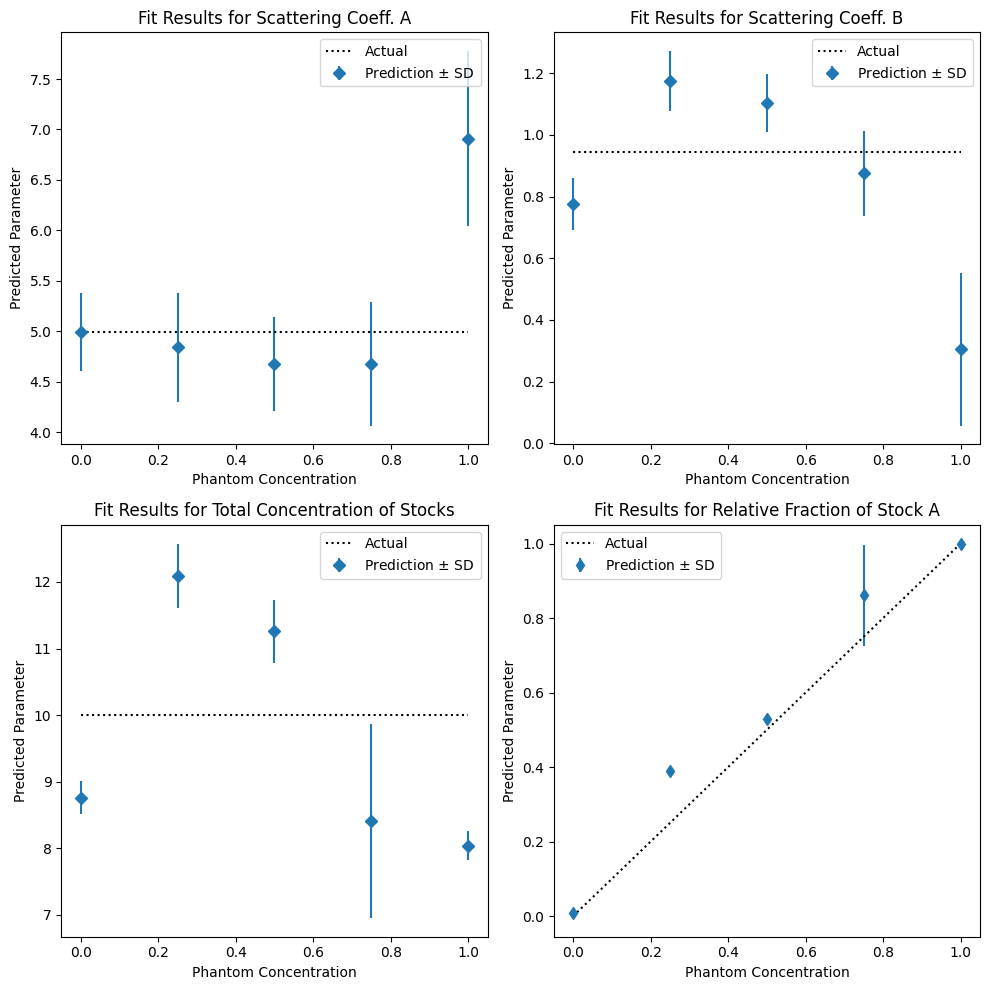

In [117]:
fig = plt.figure(figsize=(10, 10))
for i, name in enumerate(['Scattering Coeff. A', 'Scattering Coeff. B', 'Total Concentration of Stocks']):
    ax = fig.add_subplot(2, 2, i + 1)
    ax.errorbar(results[3, :, 2], results[i, :, 0], fmt='D', yerr=results[i, :, 1], label='Prediction $\pm$ SD')
    ax.hlines(results[i, 0, 2], 0, 1,  color='k', ls=':', label='Actual')
    ax.set(xlabel='Phantom Concentration', ylabel='Predicted Parameter', title=f'Fit Results for {name}')
    ax.legend()
ax = fig.add_subplot(2, 2, 4)
ax.errorbar(results[3, :, 2], results[3, :, 0], fmt='d', yerr=results[3, :, 1], label='Prediction $\pm$ SD')
ax.plot(results[3, :, 2], results[3, : ,2], color='k', ls=':', label='Actual')
ax.set(xlabel='Phantom Concentration', ylabel='Predicted Parameter', title=f'Fit Results for Relative Fraction of Stock A')
ax.legend()
plt.tight_layout()
plt.show()

# OLD PHANTOMS

In [ ]:
# Get standard paths
standard_root = r'E:\new df\03312025\ref_stdrd_080'
standard_paths = find_cycles(standard_root)

# Load standard
standard_cube = MergedHyperspectralImage(image_paths=standard_paths, scalar=0.8)
standard_cube.normalize()

# Load bg
background_cube = HyperspectralImage(image_path=r'E:\new df\03292025\standard\0_per_pwr\cycle1')
background_cube.normalize()

In [ ]:
std = np.zeros((23, 2048, 2048))
for im_path in standard_paths:
    im = read_hyperstack(img_dir=im_path, ext='.tiff') / 0.8
    md = read_metadata_json(list(im_path.glob('*metadata.json'))[0])
    im /= np.array(md['ExpTime'])[...,np.newaxis,np.newaxis]
    std += im
std /= len(standard_paths)

In [ ]:
plt.plot(np.mean(std, axis=(1,2)))
plt.plot(np.nanmean(standard_cube, axis=(1,2)))
plt.show()

In [ ]:
im_path = Path(r'E:\new df\03292025\standard\0_per_pwr\cycle1')
bg = read_hyperstack(img_dir=im_path, ext='.tiff')
md = read_metadata_json(list(im_path.glob('*metadata.json'))[0])
bg = bg / np.array(md['ExpTime'])[...,np.newaxis,np.newaxis]
plt.plot(np.mean(bg, axis=(1,2)))
plt.plot(np.nanmean(background_cube, axis=(1,2)))
plt.show()

In [ ]:
plt.plot(np.mean(std - bg, axis=(1,2)))
plt.plot(np.mean(standard_cube - background_cube, axis=(1,2)))
plt.show()

In [ ]:
phantom_cube = HyperspectralImage(image_path=r'E:\new df\03312025\phantoms\slide phantoms\phantom4\cycle1', standard=standard_cube, background=background_cube)
phantom_cube.normalize_to_standard()
plt.plot(np.mean(phantom_cube, axis=(1,2)))
plt.show()

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(5, 2.5))
for a in ax:
    a.set(xticks=[], yticks=[], frame_on=False)
plt.set_cmap('gray')

ax[0].imshow(np.mean(standard_cube, axis=0))
ax[1].imshow(np.mean(background_cube, axis=0))

ax[0].set(title='Standard')
ax[1].set(title='Background')
plt.show()

In [ ]:
# Make simulated stock solutions
wavelengths = np.arange(500, 730, 10)
stock_a = make_mix(red=12.5, green=15) / 45 * 22 / 3.4
stock_b = make_mix(yellow=20, blue=1) / 45 * 22 / 3.4
stock_a = stock_a[np.isin(wl, wavelengths)]
stock_b = stock_b[np.isin(wl, wavelengths)]
plt.plot(wavelengths, stock_a, label='Stock A', color=(12.5/27.5, 15/27.5, 0))
plt.plot(wavelengths, stock_b, label='Stock B', color=(0, 10/21, 11/21))
plt.legend()
plt.show()

In [ ]:
lut = LUT(dimensions=['mu_s', 'mu_a'], scale=50000, extrapolate=True)
def get_food_coloring_mus(wavelength, a, b, t, s):
    wl0 = 700
    conc_a = s * t
    conc_b = (1 - s) * t
    epsilons = [stock_a * conc_a, stock_b * conc_b]
    mu_s, mu_a, _ = calculate_mus(a, b, [conc_a, conc_b], epsilons, wavelength, wl0, force_feasible=False)
    return mu_s, mu_a

def model_from_food_coloring(wavelength, a, b, t, s):
    if isinstance(a, np.ndarray):
        r = np.zeros((len(wavelengths),) + a.shape)
        for i, j in itertools.product(range(r.shape[1]), range(r.shape[2])):
            mu_s, mu_a = get_food_coloring_mus(wavelength, a[i, j], b[i, j], t[i, j], s[i, j])
            r[:, i, j] = lut(mu_s, mu_a)
    else:
        mu_s, mu_a = get_food_coloring_mus(wavelength, a, b, t, s)
        r = lut(mu_s, mu_a)
    return r


In [ ]:
plt.title('Modelled Reflectance of Stock Solutions')
plt.plot(wavelengths, model_from_food_coloring(wavelengths, 1, 1, 1, 1), label='100% Stock A')
plt.plot(wavelengths, model_from_food_coloring(wavelengths, 1, 1, 1, 0), label='100% Stock B')
plt.legend()
plt.show()

In [ ]:
def fit_food_coloring(experimental, guess=(1, 1, 1, 1), bounds=((0, 0, 0, 0), (np.inf, np.inf, np.inf, 1))):
    # Get image shape
    image_shape = experimental.shape

    # Create 0 output arrays (ignore 0th dim, spectral)
    a_image = np.zeros(image_shape[1:])
    b_image = np.zeros(image_shape[1:])
    t_image = np.zeros(image_shape[1:])
    s_image = np.zeros(image_shape[1:])

    params = guess
    for i, j in itertools.product(range(image_shape[1]), range(image_shape[2])):
        r = experimental[:, i, j]
        try:
            params, _, = opt.curve_fit(model_from_food_coloring, wavelengths, r, p0=params, bounds=bounds)
        except RuntimeError:
            params = [np.nan] * 4


        a_image[i, j] = params[0]
        b_image[i, j] = params[1]
        t_image[i, j] = params[2]
        s_image[i, j] = params[3]
        params = guess if np.isnan(params).any() else params

    return a_image, b_image, t_image, s_image

In [ ]:
phantom_paths = find_cycles(r'E:\new df\03312025\phantoms\slide phantoms')
fig, axes = plt.subplots(len(phantom_paths), 4, figsize=(15, 2.5 * len(phantom_paths)))
_, axis = plt.subplots(1, 1, figsize=(5, 2.5))
for i, phantom in enumerate(tqdm(phantom_paths)):
    # Load the phantom
    phantom_cube = HyperspectralImage(image_path=phantom, standard=standard_cube, background=background_cube)
    phantom_cube.normalize_to_standard()

    # Fit it
    a, b, t, s = fit_food_coloring(np.nanmean(phantom_cube.image, axis=(1, 2), keepdims=True))
    
    ax = axes[i, :]
    ax[0].set(title='Average Reflectance (spectrally flattened)', ylabel=f'{phantom.parts[-2]}', xticks=[], yticks=[], frame_on=False)
    ax[0].imshow(np.nanmean(phantom_cube, axis=0))
    ax[1].set(title='Fitted', xticks=[], yticks=[], frame_on=False)
    ax[1].imshow(np.nanmean(model_from_food_coloring(wavelengths, a, b, t, s), axis=0))
    ax[2].set(title='Average Reflectance (spatially flattened)')
    ax[2].plot(wavelengths, np.nanmean(phantom_cube, axis=(1, 2)))
    ax[3].set(title='Fitted')
    ax[3].plot(wavelengths, np.nanmean(model_from_food_coloring(wavelengths, a, b, t, s), axis=(1, 2)))
    print(f'Phantom {phantom.name}: a={np.nanmean(a)}, b={np.nanmean(b)}, t={np.nanmean(t)}, s={np.nanmean(s)}')
    if 'phantom' in phantom.parts[-2]:
        axis.scatter(i, np.nanmean(s), label=f'{phantom.parts[-2]}')
axis.legend()
plt.show()
plt.tight_layout()